In [1]:
import pandas as pd
import numpy as np
import arrow
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor

In [2]:
id = 28
df = pd.read_csv('USvideos.csv')
df_24 = df[df['category_id'] == id]

index = int(len(df_24)*0.8)
df_train =df_24[:index]
df_test = df_24[index:]

X_train = df_train[["likes"]].to_numpy()
Y_train = df_train["views"].to_numpy()
X_test = df_test[["likes"]].to_numpy()
Y_test = df_test["views"].to_numpy()

In [3]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [4]:
Y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print("MSE: %.2f" % mse)
print("R2 Score: %.2f" % r2)



MSE: 12764605630482.05
R2 Score: 0.69


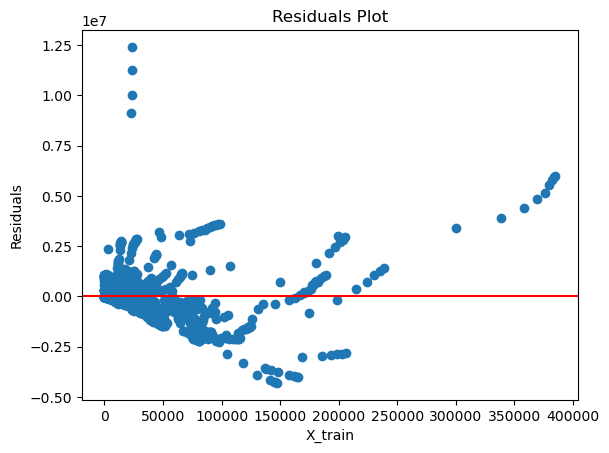

In [5]:
Y_train_pred = model.predict(X_train)

residuals = Y_train - Y_train_pred
studentized_residuals = residuals / np.sqrt(mean_squared_error(Y_train, Y_train_pred))
outliers = np.abs(studentized_residuals) > 2
plt.scatter(X_train, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('X_train')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [6]:
cook_distance = (residuals ** 2) / (model.coef_ ** 2 * X_train.var())
outliers_cooks = cook_distance > 4 / len(X_train[0])

print("Outliers based on studentized residuals:", np.where(outliers)[0])
print("Outliers based on Cook's distance:", np.where(outliers_cooks)[0])

outliers_indices = np.where(outliers)[0]


Outliers based on studentized residuals: [  10   27   83   89   98  103  113  117  134  150  187  201  202  221
  223  231  242  243  256  259  270  272  420  431  442  452  462  473
  486  501  514  577  591  603  618  633  722  733  747  759  769  781
  794  926  944  952  963  967  980  985 1001 1016 1030 1044 1062 1079
 1093 1117 1132 1148 1358 1378 1400 1401 1422 1424 1444 1446 1462 1466
 1482 1485 1501 1504 1522 1525 1539 1542 1556 1559 1569 1572 1582 1584
 1593 1595 1604 1616 1668 1677 1688 1698 1708 1718 1729 1741 1751 1761
 1770 1814 1826 1839 1852 1865 1878 1893 1905 1916]
Outliers based on Cook's distance: [ 202  221  242  256  270  733  747  759  769  781  794  926  944  963
  967  980  985 1001 1016 1030 1044 1062 1079 1093 1117 1132 1148 1446
 1466 1485 1504 1525 1542 1559 1572 1584 1595]


In [7]:
cleaned_X = np.delete(X_train, outliers_indices, axis=0)
cleaned_y = np.delete(Y_train, outliers_indices, axis=0)

model.fit(cleaned_X, cleaned_y)
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print("new MSE: %.2f" % mse)
print("new R2 Score: %.2f" % r2)

new MSE: 15488491092357.77
new R2 Score: 0.62


In [8]:
outliers_indices_Cook = np.where(outliers_cooks)[0]

cleaned_X_Cook = np.delete(X_train, outliers_indices_Cook, axis=0)
cleaned_y_Cook = np.delete(Y_train, outliers_indices_Cook, axis=0)

model.fit(cleaned_X_Cook, cleaned_y_Cook)
Y_pred_cook = model.predict(X_test)
mse_Cook = mean_squared_error(Y_test, Y_pred_cook)
r2_Cook = r2_score(Y_test, Y_pred_cook)
print("new MSE: %.2f" % mse_Cook)
print("new R2 Score: %.2f" % r2_Cook)

new MSE: 15657815618666.90
new R2 Score: 0.62


In [9]:
all_outliers_indices = np.union1d(outliers_indices, outliers_indices_Cook)

df_10_cleaned = df_24.drop(df_24.index[all_outliers_indices])

df.update(df_10_cleaned)

df = df[df.index.isin(df_10_cleaned.index) & (df['category_id'] == 10)]

df.to_csv(f'USvideos_cleaned_{id}.csv', index=False)

In [10]:
def standardize_trending_date(date_str):
    try:
        date = pd.to_datetime(date_str, format='%y.%d.%m')
        return date.strftime('%Y-%m-%d')
    except ValueError:
        return date_str

def standardize_publish_time(date_str):
    try:
        date = pd.to_datetime(date_str, format='%Y-%m-%d')
        return date.strftime('%Y-%m-%d')
    except ValueError:
        return date_str

In [11]:
df_10_cleaned['trending_date'] = df_10_cleaned['trending_date'].apply(standardize_trending_date)
df_10_cleaned['publish_time'] = df_10_cleaned['publish_time'].apply(standardize_publish_time)

In [12]:

time_series_10 = df_10_cleaned.groupby(['trending_date']).size().reset_index(name = 'counts')
print(time_series_10)

    trending_date  counts
0      2017-11-14      11
1      2017-11-15      13
2      2017-11-16      15
3      2017-11-17      16
4      2017-11-18      17
..            ...     ...
200    2018-06-10       8
201    2018-06-11       8
202    2018-06-12       6
203    2018-06-13       6
204    2018-06-14       6

[205 rows x 2 columns]


In [13]:
iddf = pd.read_csv('US_category_id.csv')

category_dict = pd.Series(iddf.title.values, index=iddf.id).to_dict()

In [14]:
from statsmodels.tsa.arima.model import ARIMA
forecast_results = {}

In [15]:
category_data = time_series_10[:-20]

In [16]:
print(category_data)

    trending_date  counts
0      2017-11-14      11
1      2017-11-15      13
2      2017-11-16      15
3      2017-11-17      16
4      2017-11-18      17
..            ...     ...
180    2018-05-21      12
181    2018-05-22      11
182    2018-05-23      10
183    2018-05-24       8
184    2018-05-25       9

[185 rows x 2 columns]


d:\Anaconda\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Anaconda\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Anaconda\envs\tensorflow_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


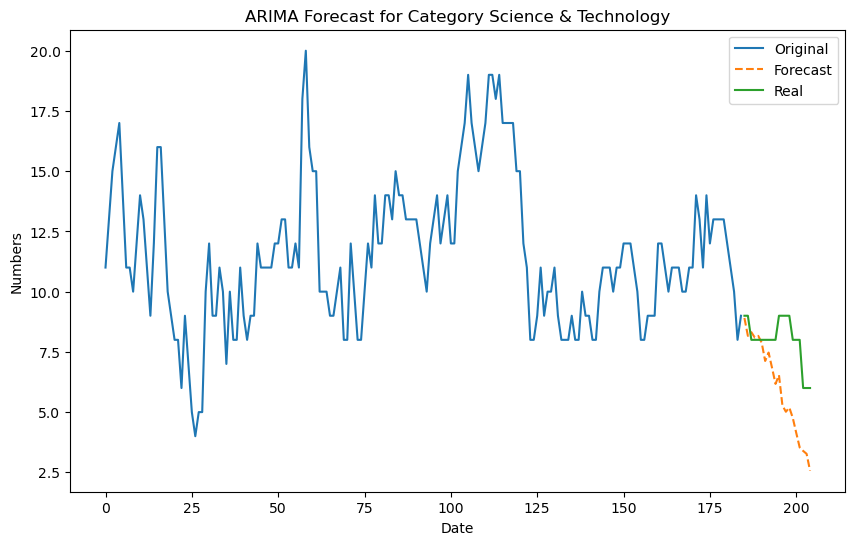

In [44]:
from matplotlib.ticker import MaxNLocator
category_data = time_series_10[:-20]
    

    
ts = category_data['counts']
original_ts = time_series_10['counts'][-20:]
model = ARIMA(ts, order=(20, 3, 5))
model_fit = model.fit()
    
forecast = model_fit.forecast(steps=20)
    
    
plt.figure(figsize=(10, 6))
plt.plot(ts, label='Original')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.plot(original_ts, label='Real')
plt.title(f'ARIMA Forecast for Category {category_dict[id]}')
plt.xlabel('Date')
plt.ylabel('Numbers')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))

plt.legend()
plt.show()